# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Нужно построить модель с максимально большим значением *accuracy* (по крайней мере 0.75).

**Описание данных**  
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.<br>
Признаки:
- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

**Содержание**<a id='toc0_'></a>    
- 1. [Общая информация о данных](#toc1_)    
- 2. [Разделение данных на выборки](#toc2_)    
- 3. [Исследование моделей](#toc3_)    
- 4. [Проверка модели на тестовой выборке](#toc4_)    
- 5. [Общий вывод](#toc5_)    
- 6. [Чек-лист готовности проекта](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Общая информация о данных](#toc0_)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('users_behavior.csv')

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Рассмотрим сооотношение классов целевого признака.

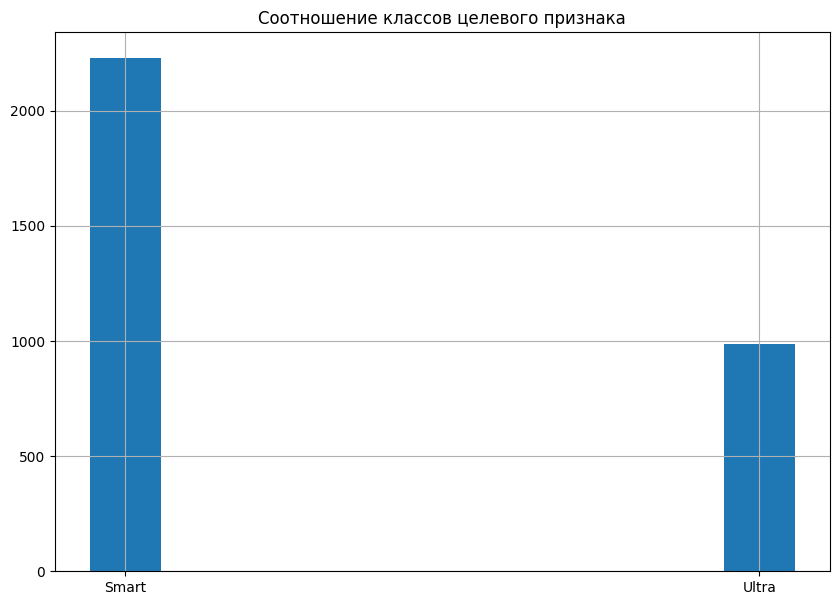

In [5]:
fig, ax = plt.subplots(figsize=(10, 7))
df.is_ultra.hist()
ax.set(title='Соотношение классов целевого признака', xticks=[0.05, 0.95])
ax.set_xticklabels(['Smart', 'Ultra']);

**Вывод по разделу 1:**

В датасете 5 столбцов, `is_ultra` - тариф, целевой признак; пропуски отсутствуют, типы данных изменять не нужно.

## 2. <a id='toc2_'></a>[Разделение данных на выборки](#toc0_)

Отделим целевой признак от остальных.

In [6]:
features = df.drop(columns=['is_ultra'])
target = df['is_ultra']

Теперь разобьём на три выборки: обучающую, валидационную и тестовую.

In [7]:
train_valid_features, test_features, train_valid_target, test_target = train_test_split(
    features, target, random_state=24542, test_size=0.2)

In [8]:
train_features, valid_features, train_target, valid_target = train_test_split(
    train_valid_features, train_valid_target, random_state=24542, test_size=0.25)

Выведем явно размеры получившихся выборок, это поможет быстро оценить корректность разделения на выборки.

In [9]:
for sample in [train_features, valid_features, test_features, train_target, valid_target, test_target]:
    print(sample.shape)

(1928, 4)
(643, 4)
(643, 4)
(1928,)
(643,)
(643,)


**Вывод по разделу 2:**

Данные разбиты на выборки в пропорции 3:1:1.

## 3. <a id='toc3_'></a>[Исследование моделей](#toc0_)

Для начала исследуем простую модель - дерево решений - при разных значениях максимальной глубины.
<br>Рассмотрим как при изменении гиперпараметров меняется точность на обучающем и валидационых наборах.

In [10]:
best_tree_model = None
best_tree_accuracy = 0
train_accuracy, valid_accuracy = [], []
for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=54524, max_depth=depth)
    model.fit(train_features, train_target)
    
    train_predictions = model.predict(train_features)
    train_accuracy.append(accuracy_score(train_target, train_predictions))
    
    valid_predictions = model.predict(valid_features)
    
    accuracy = accuracy_score(valid_target, valid_predictions)
    valid_accuracy.append(accuracy)
    
    print(f'При depth = {depth}, accuracy = {accuracy}')
    if accuracy > best_tree_accuracy:
        best_tree_model = model

При depth = 1, accuracy = 0.7402799377916018
При depth = 2, accuracy = 0.7900466562986003
При depth = 3, accuracy = 0.8055987558320373
При depth = 4, accuracy = 0.7807153965785381
При depth = 5, accuracy = 0.7900466562986003
При depth = 6, accuracy = 0.7916018662519441
При depth = 7, accuracy = 0.7962674961119751
При depth = 8, accuracy = 0.7900466562986003
При depth = 9, accuracy = 0.8040435458786936
При depth = 10, accuracy = 0.7962674961119751


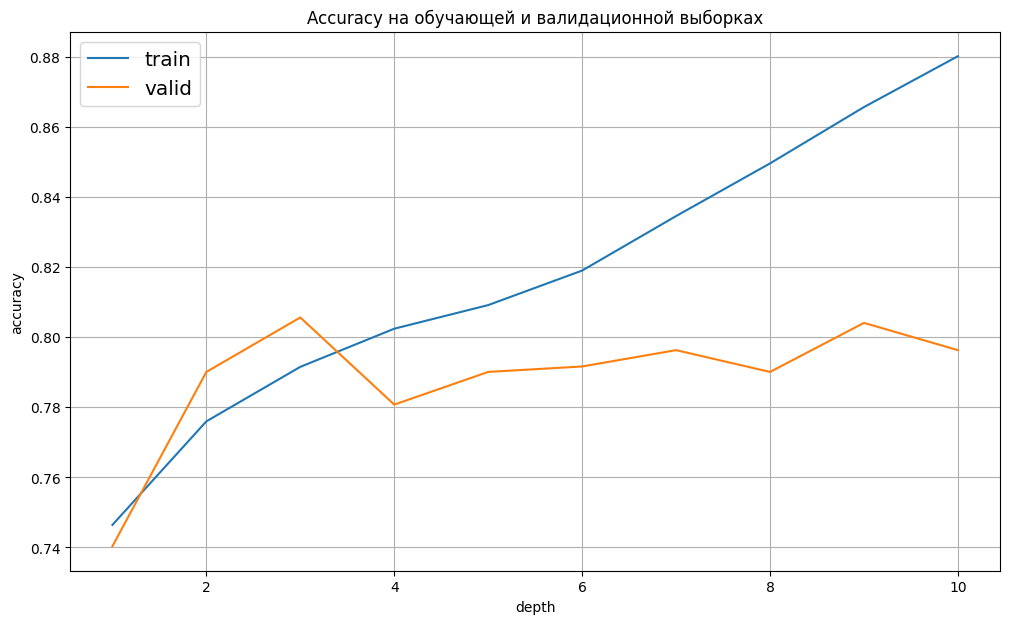

In [11]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.set(xlabel='depth', ylabel='accuracy')
plt.title('Accuracy на обучающей и валидационной выборках')
ax.plot(range(1, 11), train_accuracy, label='train')
ax.plot(range(1, 11), valid_accuracy, label='valid')
ax.legend(fontsize='x-large');
ax.grid(True)

Здесь наибольшую долю правильных ответов показала модель с depth = 3.

Теперь изучим модель "Случайный лес". Будем изменять количество деревьев и максимальную глубину.

In [12]:
best_forest_model = None
best_forest_accuracy = 0
best_n_est, best_depth = 0, 0
train_accuracy, valid_accuracy = [], []

for n_est in range(10, 101, 10):
    for depth in range(1, 11):
        model = RandomForestClassifier(
            random_state=54524, n_estimators=n_est, max_depth=depth)
        
        model.fit(train_features, train_target)
        
        valid_predictions = model.predict(valid_features)
        accuracy = accuracy_score(valid_target, valid_predictions)
        
        if accuracy > best_forest_accuracy:
            best_forest_accuracy = accuracy
            best_n_est, best_depth = n_est, depth
    
    train_predictions = model.predict(train_features)
    train_accuracy.append(accuracy_score(train_target, train_predictions))
    valid_accuracy.append(accuracy)
    

print(f'''Наибольше значение accuracy - {best_forest_accuracy} - достигается при depth = {best_depth} и n_estimators = {best_n_est}''')

Наибольше значение accuracy - 0.8195956454121306 - достигается при depth = 10 и n_estimators = 100


График при глубине, равной 10:

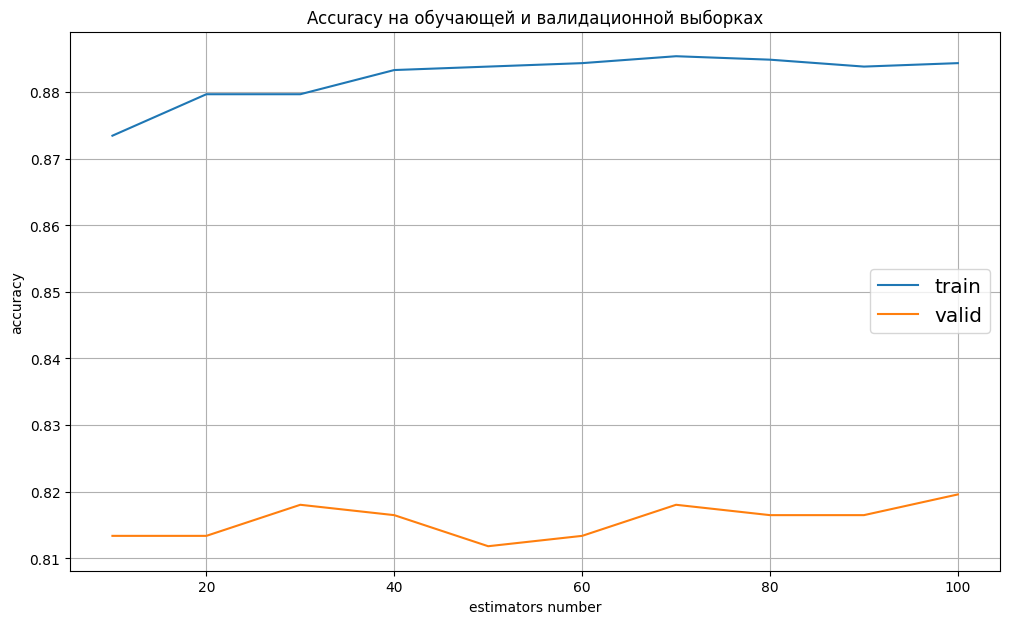

In [13]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.set(xlabel='estimators number', ylabel='accuracy')
plt.title('Accuracy на обучающей и валидационной выборках')
ax.plot(range(10, 101, 10), train_accuracy, label='train')
ax.plot(range(10, 101, 10), valid_accuracy, label='valid')
ax.legend(fontsize='x-large');
ax.grid(True)

Случайный лес исследован следующим образом:
 - исследовано 10 значений гиперпараметров
 - модель обучена на обучающем наборе
 - получена оценка качества на валидационном наборе
 - перебор гиперпараметров осуществляется в цикле


Лучшая модель имеет такие гиперпараметры: depth = 10, n_estimators = 101.


Также изучим логистическую регрессию.

In [14]:
model = LogisticRegression(random_state=54524, max_iter=1000)
model.fit(train_features, train_target)

train_predictions = model.predict(train_features)
train_accuracy = accuracy_score(train_target, train_predictions)

valid_predictions = model.predict(valid_features)

valid_accuracy = accuracy_score(valid_target, valid_predictions)

print(f'Accuracy на тренировочной выборке = {train_accuracy}, на валидационной = {valid_accuracy}')

Accuracy на тренировочной выборке = 0.6981327800829875, на валидационной = 0.7076205287713841


Логистическая регрессия показала себя хуже остальных моделей.

**Вывод по разделу 3:**

Лучшая модель - случайный лес со следующими гиперпараметрами: depth = 10, n_estimators = 100.

## 4. <a id='toc4_'></a>[Проверка модели на тестовой выборке](#toc0_)

Найдём *accuracy* модели, полученной в предыдущем разделе, на тестовой выборке.

Сейчас, когда гиперпараметры подобраны и валидационная выборка нам не нужна, мы можем обучить модель на большой выборке (обучающая + валидационная), а тестирование новой модели произвести уже на тестовой выборке.

In [15]:
best_model = RandomForestClassifier(
                random_state=42524, n_estimators=100, max_depth=10)

best_model.fit(train_valid_features, train_valid_target)

predictions = best_model.predict(test_features)

accuracy = accuracy_score(test_target, predictions)
print(f'Итоговое значение accuracy модели: {accuracy}')

Итоговое значение accuracy модели: 0.8227060653188181


Поставленная цель - достичь *accuracy* не менее 0.75 - достигнута.

## 5. <a id='toc5_'></a>[Общий вывод](#toc0_)

- В ходе исследования изучены три модели с различными гиперпараметрами: дерево решений, случайный лес и логистическая регрессия.
- В качестве лучшей модели выбрана модель "случайного леса" количество деревьев - 100, глубина - 10.  
- Полученное значение *accuracy* составляет `0.82`.

## 6. <a id='toc6_'></a>[Чек-лист готовности проекта](#toc0_)

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Данные загружены и изучены
- [x] Данные разбиты на три выборки
- [x] Проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
